# Fitting linecuts using the lmfit package

## Import functions

In [41]:
from nxs_analysis_tools.datareduction import load_data, Scissors
from nxs_analysis_tools.fitting import LinecutModel

from lmfit.models import GaussianModel, LinearModel
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [3]:
data = load_data('example_data/sample_name/15/example_hkli.nxs')

data:NXdata
  @axes = ['H', 'K', 'L']
  @signal = 'counts'
  H = float64(100)
  K = float64(150)
  L = float64(200)
  counts = float64(100x150x200)


## Perform linecuts

In [4]:
s = Scissors(data=data)

In [5]:
linecut = s.cut_data(center=(0,0,0), window=(0.1,0.5,0.1))

## The `LinecutModel` class

The workhorse of the fitting algorithm here is the `LinecutModel` class which wraps both the `Model` and `ModelResult` classes of the `lmfit` package, among other information.

In [6]:
lm = LinecutModel(data=linecut)

## Create `lmfit` model

Use the `.set_model_components()` method to set the model to be used for fitting the linecut. The `model_components` parameter must be a `Model`, `CompositeModel`, or `list` of `Model` objects.

In [7]:
# Using a list of Model objects
lm.set_model_components([GaussianModel(prefix='peak'), LinearModel(prefix='background')])

# Using a CompositeModel
lm.set_model_components(GaussianModel(prefix='peak') + LinearModel(prefix='background'))

Upon setting the model, the `.params` attribute is initialized with a `Parameters` object which holds the parameters for all components of the model.

In [8]:
lm.params

name,value,initial value,min,max,vary,expression
peakamplitude,1.00000000,None,-inf,inf,True,
peakcenter,0.00000000,None,-inf,inf,True,
peaksigma,1.00000000,None,0.00000000,inf,True,
backgroundslope,1.00000000,None,-inf,inf,True,
backgroundintercept,0.00000000,None,-inf,inf,True,
peakfwhm,2.35482000,None,-inf,inf,False,2.3548200*peaksigma
peakheight,0.39894230,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Performing an initial guess

Use the `.guess()` method to perform an initial guess, which will overwrite any changes made to the parameter values and constraints set in the `.params` attribute.

In [13]:
lm.guess()

To view the guessed initial values, we can inspect the `.params` attribute.

In [14]:
lm.params

name,value,initial value,min,max,vary,expression
peakamplitude,219.885366,219.88536567293792,-inf,inf,True,
peakcenter,0.00000000,0.0,-inf,inf,True,
peaksigma,0.06040268,0.06040268456375841,0.00000000,inf,True,
backgroundslope,2.3853e-14,2.3853065274578794e-14,-inf,inf,True,
backgroundintercept,180.019533,180.0195329458017,-inf,inf,True,
peakfwhm,0.14223745,None,-inf,inf,False,2.3548200*peaksigma
peakheight,1452.27938,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Visualize the initial guesses

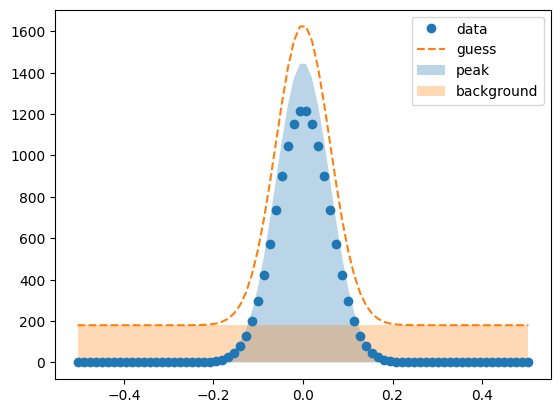

In [ ]:
lm.plot_initial_guess()

## Set parameter constraints

All constraints are set by accessing the individiual parameters through the `.params` attribute. See [https://lmfit.github.io/lmfit-py/constraints.html](https://lmfit.github.io/lmfit-py/constraints.html) for more information on mathematical constraints allowed by `lmfit`.

In [15]:
# Constrain the peak amplitude to be positive
lm.params['peakamplitude'].set(min=0)

# Constrain the range of the peak center
lm.params['peakcenter'].set(min=-0.1, max=0.1)

If we inspect the `.params` attribute again, we should see that the constraints are implemented.

In [16]:
lm.params

name,value,initial value,min,max,vary,expression
peakamplitude,219.885366,219.88536567293792,0.00000000,inf,True,
peakcenter,0.00000000,0.0,-0.10000000,0.10000000,True,
peaksigma,0.06040268,0.06040268456375841,0.00000000,inf,True,
backgroundslope,2.3853e-14,2.3853065274578794e-14,-inf,inf,True,
backgroundintercept,180.019533,180.0195329458017,-inf,inf,True,
peakfwhm,0.14223745,None,-inf,inf,False,2.3548200*peaksigma
peakheight,1452.27938,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Perform the fit

The `.fit()` method here automatically assumes the parameter values and constraints currently stored in the `.params` attribute and feeds them to the `.fit()` method from `lmfit`. 

In [17]:
lm.fit()

## Visualize the fit

Once the fit is complete, we can visualize the fit and the residuals using the `.plot_fit()` method.

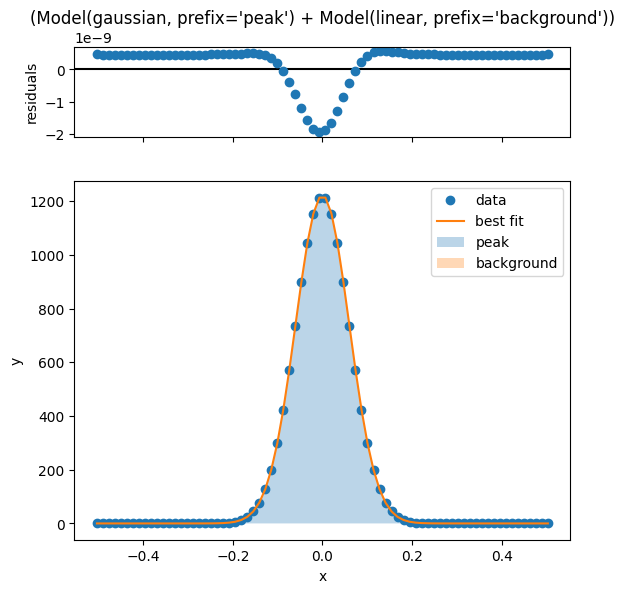

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 76
    # variables        = 5
    chi-square         = 3.4000e-17
    reduced chi-square = 4.7888e-19
    Akaike info crit   = -3201.06774
    Bayesian info crit = -3189.41407
    R-squared          = 1.00000000
##  Warning: uncertainties could not be estimated:
    backgroundslope:      at initial value
[[Variables]]
    peakamplitude:        183.644087 (init = 219.8854)
    peakcenter:          -1.3614e-14 (init = 0)
    peaksigma:            0.06000000 (init = 0.06040268)
    backgroundslope:      1.0937e-16 (init = 2.385307e-14)
    backgroundintercept: -4.6068e-10 (init = 180.0195)
    peakfwhm:             0.14128920 == '2.3548200*peaksigma'
    peakheight:           1221.05658 == '0.3989423*peakamplitude/max(1e-15, peaksigma)'


<Axes: xlabel='x', ylabel='y'>

In [18]:
lm.plot_fit()

The number of x values used to evaluate the fit curve can be set using the `numpoints` parameter, and any keyword arguments here will be passed to the `.plot()` method of the underlying `ModelResult` object.

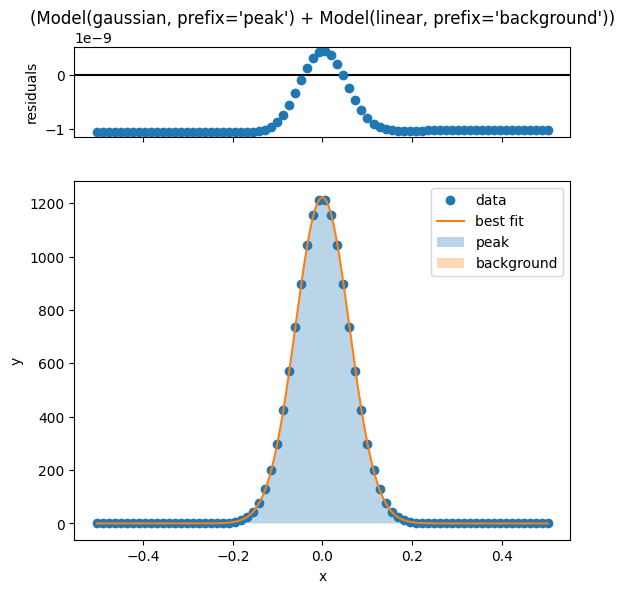

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 76
    # variables        = 5
    chi-square         = 6.7360e-17
    reduced chi-square = 9.4873e-19
    Akaike info crit   = -3149.10859
    Bayesian info crit = -3137.45492
    R-squared          = 1.00000000
##  Warning: uncertainties could not be estimated:
    backgroundslope:      at initial value
[[Variables]]
    peakamplitude:        183.644087 (init = 219.8854)
    peakcenter:           3.7323e-15 (init = 0)
    peaksigma:            0.06000000 (init = 0.06040268)
    backgroundslope:      4.9078e-11 (init = 2.562793e-14)
    backgroundintercept: -1.0334e-09 (init = 180.0195)
    peakfwhm:             0.14128920 == '2.3548200*peaksigma'
    peakheight:           1221.05658 == '0.3989423*peakamplitude/max(1e-15, peaksigma)'


<Axes: xlabel='x', ylabel='y'>

In [15]:
lm.plot_fit(numpoints=1000)

## Access the fit values

The x and y values of the fit are stored in the `.x` (identical to the raw x values) and the `.y_fit` attributes.

In [16]:
lm.x

array([-0.503356, -0.489933, -0.47651 , ...,  0.47651 ,  0.489933,
        0.503356])

In [17]:
lm.y_fit

array([-1.057442e-09, -1.053363e-09, -1.032177e-09, ..., -9.854041e-10,
       -1.005273e-09, -1.008035e-09])

The residuals are stored within the `ModelResult` class of the lmfit package, which is stored in the `.modelresult` attribute of the `LinecutModel` class.

In [18]:
lm.modelresult.residual

array([-1.059696e-09, -1.057668e-09, -1.056797e-09, ..., -1.010025e-09,
       -1.009578e-09, -1.010289e-09])

If `.plot_fit()` has already been called, then the evaluated data composing the fit curve can be found in `.x_eval` and `.y_eval`.

In [20]:
lm.x_eval

array([-0.503356, -0.489933, -0.47651 , ...,  0.47651 ,  0.489933,
        0.503356], shape=(76,))

In [21]:
lm.y_eval

array([-4.600434e-10, -4.566233e-10, -4.360954e-10, ..., -4.360953e-10,
       -4.566232e-10, -4.600433e-10], shape=(76,))

If `.plot_fit()` has not been called, then evaluating the fit can be done in the standard `lmfit` way through the `ModelResult` object for either the total model or its individual components.

In [55]:
# Evaulate the total model
lm.modelresult.eval(x=np.linspace(-0.5,0.5,1000))

array([-4.596638e-10, -4.595123e-10, -4.593387e-10, ..., -4.593386e-10,
       -4.595122e-10, -4.596637e-10], shape=(1000,))

In [56]:
# Evaulate only the background component
lm.modelresult.components[1].eval(x=np.linspace(-0.5,0.5,1000))

array([-0.5     , -0.498999, -0.497998, ...,  0.497998,  0.498999,
        0.5     ], shape=(1000,))

You may also opt to evaluate all components at the same time, but separated by their individual contribution.

In [57]:
# Evaluate all components separately
evaluated_components = lm.modelresult.eval_components(x=np.linspace(-0.5,0.5,1000))

Using this approach, a `dict` is generated where the contribution of each component is labeled by its prefix.

In [58]:
evaluated_components

{'peak': array([1.016404e-12, 1.167844e-12, 1.341475e-12, ..., 1.341475e-12,
        1.167844e-12, 1.016404e-12], shape=(1000,)),
 'background': array([-4.606802e-10, -4.606802e-10, -4.606802e-10, ..., -4.606801e-10,
        -4.606801e-10, -4.606801e-10], shape=(1000,))}

In [59]:
evaluated_components['peak']

array([1.016404e-12, 1.167844e-12, 1.341475e-12, ..., 1.341475e-12,
       1.167844e-12, 1.016404e-12], shape=(1000,))

In [60]:
evaluated_components['background']

array([-4.606802e-10, -4.606802e-10, -4.606802e-10, ..., -4.606801e-10,
       -4.606801e-10, -4.606801e-10], shape=(1000,))

These can then be plotted together to show their individual contributions. See below for an example.

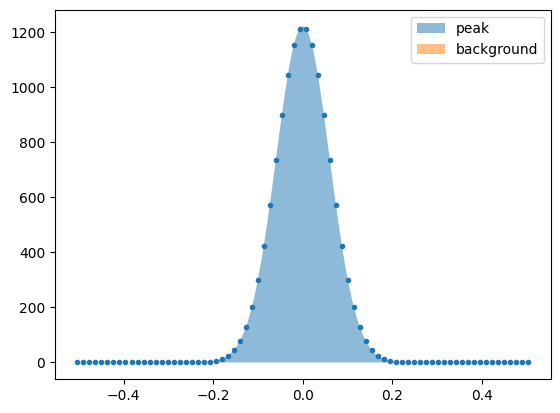

In [65]:
plt.plot(lm.x, lm.y, '.')
plt.fill_between(np.linspace(-0.5,0.5,1000), evaluated_components['peak'], alpha=0.5, label='peak')
plt.fill_between(np.linspace(-0.5,0.5,1000), evaluated_components['background'], alpha=0.5, label='background')
plt.legend()

## Viewing the fit report

In [19]:
lm.print_fit_report()

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 76
    # variables        = 5
    chi-square         = 6.7360e-17
    reduced chi-square = 9.4873e-19
    Akaike info crit   = -3149.10859
    Bayesian info crit = -3137.45492
    R-squared          = 1.00000000
##  Warning: uncertainties could not be estimated:
    backgroundslope:      at initial value
[[Variables]]
    peakamplitude:        183.644087 (init = 219.8854)
    peakcenter:           3.7323e-15 (init = 0)
    peaksigma:            0.06000000 (init = 0.06040268)
    backgroundslope:      4.9078e-11 (init = 2.562793e-14)
    backgroundintercept: -1.0334e-09 (init = 180.0195)
    peakfwhm:             0.14128920 == '2.3548200*peaksigma'
    peakheight:           1221.05658 == '0.3989423*peakamplitude/max(1e-15, peaksigma)'
